# ネットワーク可制御性（最小支配集合に基づく）

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 35.2 MB/s eta 0:00:00


In [4]:
import pulp

In [5]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.4 MB/s eta 0:00:00


In [6]:
import igraph as ig

マッチングに基づいてドライバーノードを求めるための関数

In [7]:
def get_mds_domination(g, relax=False):
  m_g = nx.adjacency_matrix(g).todense()
  m_g = np.array(m_g).T
  np.fill_diagonal(m_g, 1)

  n_nodes = g.number_of_nodes()

  # Create optimization problem
  prob = pulp.LpProblem("MinimumDominatingSet", pulp.LpMinimize)

  # Decision variables
  if relax:
    x = pulp.LpVariable.dicts("node", range(n_nodes), lowBound=0, upBound=1)
  else:
    x = pulp.LpVariable.dicts("node", range(n_nodes), cat='Binary')

  # Objective function: minimize the number of nodes in dominating set
  prob += pulp.lpSum([x[i] for i in range(n_nodes)])

  # Constraints: each node must be dominated by at least one node
  for i in range(n_nodes):
    prob += pulp.lpSum([m_g[i,j] * x[j] for j in range(n_nodes)]) >= 1

  # Solve the problem
  prob.solve()

  # Get solution
  solution = [round(x[i].value()) for i in range(n_nodes)]

  return {
      "minimum dominating set size": sum(solution),
      "is dominator": solution
  }

## ネットワークの読み込み
モデルネットワークを例にする。

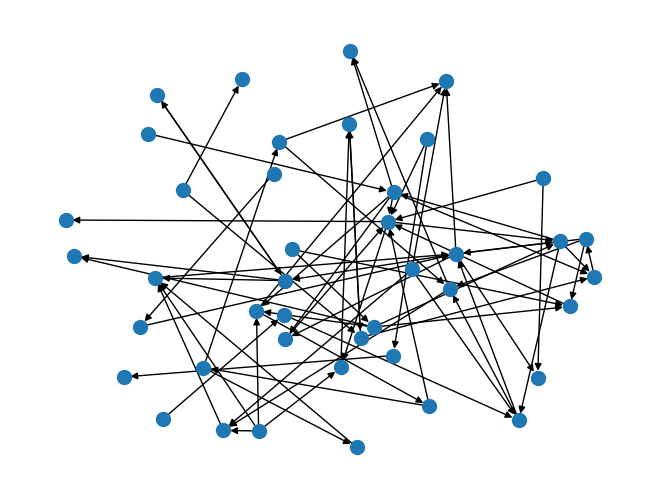

In [8]:
random.seed(123)
g = ig.GraphBase.Static_Power_Law(50, 70, 2.1, 2.1)
# igraph to networkx
edgelist = g.get_edgelist()
g = nx.DiGraph(edgelist)

# ネットワークの表示
pos = nx.spring_layout(g, k=1.0, seed=123)
nx.draw(g, node_size=100, pos=pos)

## ネットワークのドライバノードを見つける
最小ドライバーノード集合（minimum driver node set）を得る

In [9]:
mds = get_mds_domination(g, relax = False)
# relax: 論理値，バイナリ整数計画問題を線形計画緩和するかどうか。デフォルトはFalse（しない）。

結果にアクセスする

In [10]:
# 最小支配集合サイズ
mds["minimum dominating set size"]

17

In [ ]:
# ドライバノードメンバーシップ: ドライバ（支配）ノードである (1) でない (0)
mds["is dominator"]

結果の表示

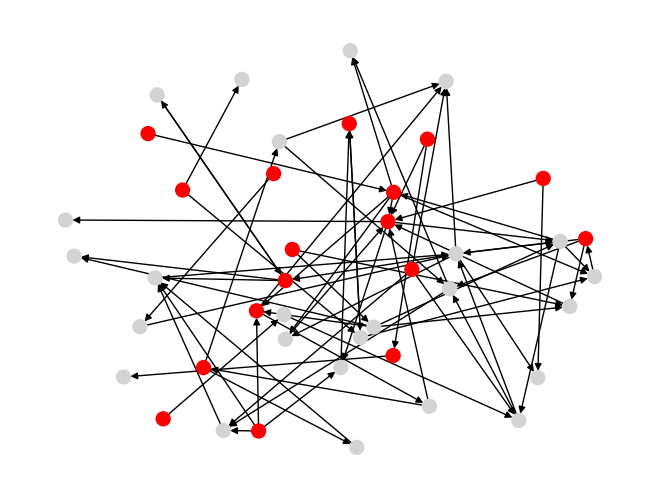

In [12]:
# ノードの色を設定（ドライバーノードは赤、それ以外は青）
node_colors = ['red' if x == 1 else 'lightgray' for x in mds["is dominator"]]
nx.draw(g, node_size=100, pos=pos, node_color=node_colors)

## ネットワーク可制御性に基づいてノードを「不必要」「中立」「不可欠」に分類する。
関数の準備

In [13]:
def node_classification_controllability(g, get_mds=get_mds_domination, relax=False):
  # ノードの分類
  node_class = []
  # 元のグラフでの最小ドライバーノードセットのサイズ
  mds_original = get_mds(g, relax)["minimum dominating set size"]

  # 各ノードについて処理
  for v in g.nodes():
    # ノードvを削除したグラフを作成
    g_del = g.copy()
    g_del.remove_node(v)

    # 削除後のグラフでの最小ドライバーノードセットのサイズ
    mds_del = get_mds(g_del, relax)["minimum dominating set size"]

    # ノードの分類
    if mds_original == mds_del:
        node_class.append("neutral")
    elif mds_original < mds_del:
        node_class.append("indispensable")
    else:  # mds_original > mds_del
        node_class.append("dispensable")

  return node_class

分類を得る

In [14]:
classifications = node_classification_controllability(g, get_mds = get_mds_domination, relax = False)

結果を表示する

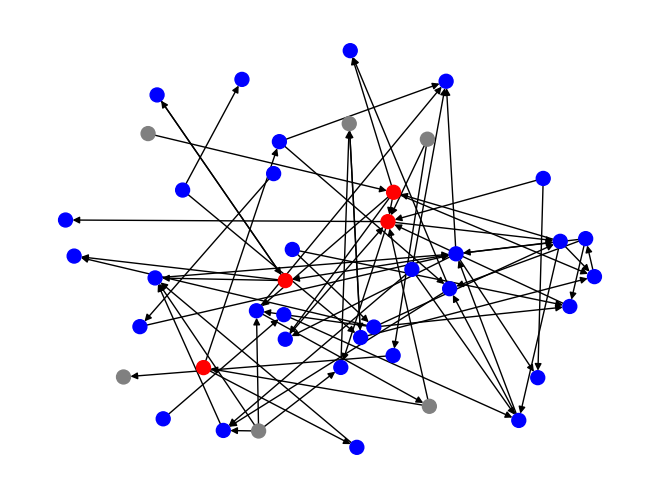

In [15]:
# 分類に基づく色分け
color_map = {
    "neutral": "blue",
    "indispensable": "red",
    "dispensable": "gray"
}
node_colors = [color_map[c] for c in classifications]

# ネットワークの表示
nx.draw(g, pos=pos, node_size=100, node_color=node_colors)

# やってみよう
* このNotebookを参考にして，生物ネットワークを解析してみよう（`data`に様々ある）。
* Notebookを参考に自分のデータを解析してみよう。